# Process and remove artifacts from .vhdr EEG Data

In [ ]:
import mne
import os
from tqdm import tqdm_notebook
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib tk

In [ ]:
raw = mne.io.read_raw("raw_full/001.vhdr")

Using matplotlib as 2D backend.


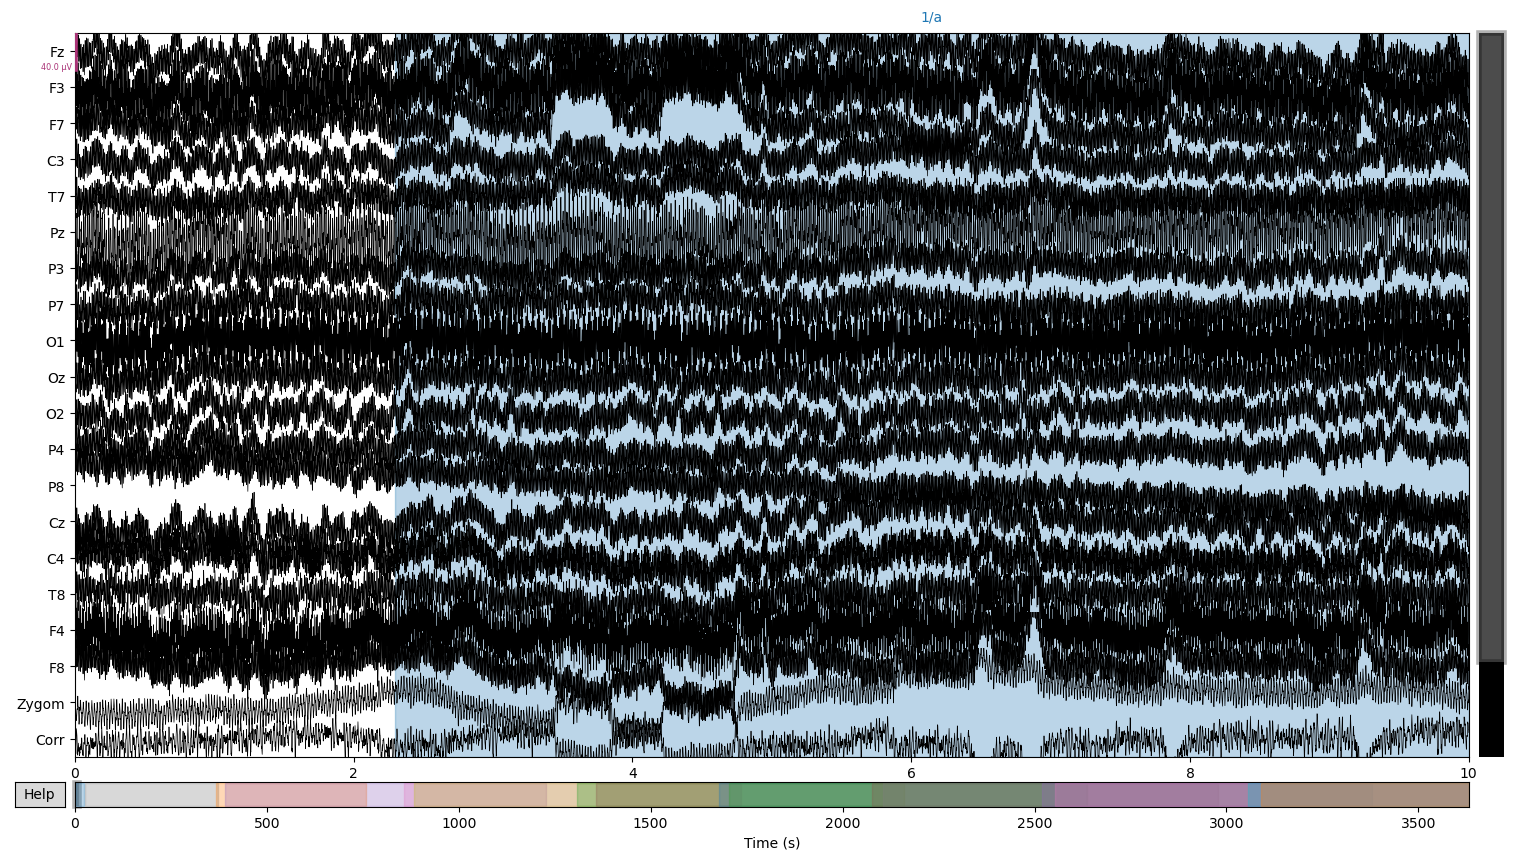

Channels marked as bad:
none


In [3]:
raw.plot()

In [3]:
film_order = None

In [4]:
first_film_order = [1, 4, 8, 5, 3, 7, 6, 2]
# event_order = first_film_order + list(np.array(first_film_order) + 8)
# second_film_order = [2, 6, 7, 5, 3, 8, 4, 1]
# third_film_order = [8, 3, 2, 6, 1, 4, 7, 5]
# forth_film_order = [5, 7, 1, 6, 4, 2, 8, 3]
# fifth_film_order = [7, 2, 4, 8, 1, 5, 3, 6]
# eleventh_subject_order = [1, 8, 5, 3, 6, 2]
film_order = first_film_order

# Find events from Mark channel

In [5]:
def find_first_relax(stimulus):
    i = 0
    while i < len(stimulus[1]) and stimulus[0][0][i] < -0.0007:
        i += 1
    return i

In [6]:
def make_stim(stimulus):
    events = []
    new_stim_ch = []
    i = 0
    j = find_first_relax(stimulus)
    while i < len(stimulus[1]):
        if stimulus[0][0][i] < -0.0007 and i < j:
            new_stim_ch.append(0.0)
        elif stimulus[0][0][i] < -0.0007 and i > j:
            left = i
            while i < len(stimulus[1]) and stimulus[0][0][i] < -0.0007:
                new_stim_ch.append(1.0)
                i += 1
            right = i - 1
            if stimulus[1][left] < 60:
                events.append([0.0, stimulus[1][left]])
                new_stim_ch[0:left] = [2.0] * len(new_stim_ch[0:left])
            else:
                events.append([stimulus[1][left] - 60, stimulus[1][left]])
                new_stim_ch[left - (60 * 1000 + 1)                            : left] = [2.0] * (60 * 1000 + 1)
            events.append([stimulus[1][left] + 0.001, stimulus[1][right]])
            j = right + 1
            new_stim_ch.append(2.0)
        else:
            new_stim_ch.append(0.0)
        i += 1
    return events, new_stim_ch

In [7]:
events = make_stim(raw["Mark"])

In [10]:
for [start, end] in events[0]:
    print("Start", start, " ", "end", end)

Start 38.016000000000005   end 98.016
Start 98.01700000000001   end 416.161
Start 422.162   end 482.162
Start 482.16299999999995   end 927.645
Start 932.946   end 992.946
Start 992.947   end 1386.727
Start 1390.979   end 1450.979
Start 1450.98   end 1711.005
Start 1716.323   end 1776.323
Start 1776.324   end 2143.403
Start 2147.671   end 2207.671
Start 2207.672   end 2555.584
Start 2560.002   end 2620.002
Start 2620.003   end 3011.383
Start 3016.284   end 3076.284
Start 3076.2850000000003   end 3470.982


In [11]:
assert len(events[0]) == 16

# Add Mark channel as mne stim array to the data

In [17]:
info = mne.create_info(["STI"], raw.info["sfreq"], ["stim"])
stim_raw = mne.io.RawArray([events[1]], info)
raw.add_channels([stim_raw], force_update_info=True)

Creating RawArray with float64 data, n_channels=1, n_times=3645500
    Range : 0 ... 3645499 =      0.000 ...  3645.499 secs
Ready.


<RawBrainVision | 021.eeg, 25 x 3645500 (3645.5 s), ~695.4 MB, data loaded>

In [18]:
def find_events(stimulus):
    i = 0
    interval_len = 0
    onsets = []
    durations = []
    descriptions = []
    while i < len(stimulus):
        while (
            i < len(stimulus) - 1
            and stimulus[i] == stimulus[i + 1]
            and stimulus[i] != 0
        ):
            interval_len += 1
            i += 1
        if interval_len != 0:
            onsets.append(i - interval_len)
            durations.append(interval_len)
        interval_len = 0
        i += 1
    return (
        np.array(onsets) / 1e3,
        np.array(durations) / 1e3,
        np.array(descriptions) / 1e3,
    )

In [19]:
events = find_events(raw["STI"][0][0])
events

(array([  38.015,   98.016,  422.161,  482.162,  932.945,  992.946,
        1390.978, 1450.979, 1716.322, 1776.323, 2147.67 , 2207.671,
        2560.001, 2620.002, 3016.283, 3076.284]),
 array([ 60.   , 318.145,  60.   , 445.483,  60.   , 393.781,  60.   ,
        260.026,  60.   , 367.08 ,  60.   , 347.913,  60.   , 391.381,
         60.   , 394.698]),
 array([], dtype=float64))

In [20]:
film_order = None

In [21]:
first_film_order = ["a", "d", "h", "e", "c", "g", "f", "b"]
# second_film_order = ['b', 'f', 'g', 'e', 'c', 'h', 'd', 'a']
# third_film_order = ['h', 'c', 'b', 'f', 'a', 'd', 'g', 'e']
# forth_film_order = ['e', 'g', 'a', 'f', 'd', 'b', 'h', 'c']
# fifth_film_order = ['g', 'b', 'd', 'h', 'a', 'e', 'c', 'f']
# eleventh_subject_order = ['a', 'd', 'h', 'e', 'c', 'g']
film_order = first_film_order

In [22]:
def make_descriptions_from_vmrk():
    description = []
    for i in range(0, 8):
        description.append("relax_" + film_order[i])
        description.append("watch_" + film_order[i])
    return description

In [23]:
my_annot = mne.Annotations(
    onset=events[0],  # in seconds
    duration=events[1],  # in seconds, too
    description=make_descriptions_from_vmrk(),
)

In [24]:
raw.set_annotations(my_annot)

<RawBrainVision | 021.eeg, 25 x 3645500 (3645.5 s), ~695.4 MB, data loaded>

# Find best sampling frequency to downsample

In [26]:
raw.load_data()
current_sfreq = raw.info["sfreq"]
desired_sfreq = 128  # Hz
decim = np.round(current_sfreq / desired_sfreq).astype(int)
obtained_sfreq = current_sfreq / decim
lowpass_freq = obtained_sfreq / 3.0
print(current_sfreq, desired_sfreq, decim, obtained_sfreq, lowpass_freq)

1000.0 128 8 125.0 41.666666666666664


In [ ]:
raw_downsampled = raw.copy().resample(obtained_sfreq)
raw_downsampled.info

In [ ]:
raw_downsampled.set_channel_types(
    mapping={
        "Fz": "eeg",
        "F3": "eeg",
        "F7": "eeg",
        "VEOG": "eog",
        "C3": "eeg",
        "T7": "eeg",
        "Pz": "eeg",
        "P3": "eeg",
        "P7": "eeg",
        "O1": "eeg",
        "Oz": "eeg",
        "O2": "eeg",
        "P4": "eeg",
        "P8": "eeg",
        "Cz": "eeg",
        "C4": "eeg",
        "T8": "eeg",
        "F4": "eeg",
        "F8": "eeg",
        "Pulse": "ecg",
        "Zygom": "emg",
        "Corr": "emg",
        "Mark": "misc",
        "EDA": "misc",
        "STI": "stim",
    }
)

raw_downsampled.set_montage("standard_1020")

# Applying RANSAC to detect and interpolate bad channels

In [29]:
from pyprep.prep_pipeline import PrepPipeline


montage_kind = "standard_1020"

montage = mne.channels.make_standard_montage(montage_kind)

prep_params = {
    "ref_chs": "eeg",
    "reref_chs": "eeg",
    "line_freqs": [],
}


prep = PrepPipeline(raw_downsampled, prep_params, montage)

prep.fit()

Setting up high-pass filter at 1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Filter length: 413 samples (3.304 sec)

Setting up high-pass filter at 1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Filter length: 413 samples (3.304 sec)

Executing RANSAC
This may take a while, so be patient...
Progress: 10%... 20%... 30%... 40%... 50%... 60%... 70%... 80%... 90%... 

2022-03-18 08:52:56,473 - pyprep.reference - INFO - Bad channels: {'bad_by_nan': [], 'bad_by_flat': [], 'bad_by_deviation': [], 'bad_by_hf_noise': [], 'bad_by_correlation': ['T7'], 'bad_by_SNR': [], 'bad_by_dropout': [], 'bad_by_ransac': [], 'bad_all': ['T7']}


100%

RANSAC done!
Executing RANSAC
This may take a while, so be patient...
Progress: 10%... 20%... 30%... 40%... 50%... 60%... 70%... 80%... 90%... 

2022-03-18 08:53:08,249 - pyprep.reference - INFO - Bad channels: {'bad_by_nan': [], 'bad_by_flat': [], 'bad_by_deviation': [], 'bad_by_hf_noise': [], 'bad_by_correlation': ['T7', 'Fz', 'F3', 'T8'], 'bad_by_SNR': [], 'bad_by_dropout': [], 'bad_by_ransac': [], 'bad_all': ['T7', 'Fz', 'F3', 'T8']}


100%

RANSAC done!
Interpolating bad channels
    Automatic origin fit: head of radius 89.4 mm
Computing interpolation matrix from 14 sensor positions
Interpolating 4 sensors


2022-03-18 08:53:08,433 - pyprep.reference - INFO - Iterations: 1


Executing RANSAC
This may take a while, so be patient...
Progress: 10%... 20%... 30%... 40%... 50%... 60%... 70%... 80%... 90%... 

2022-03-18 08:53:20,344 - pyprep.reference - INFO - Bad channels: {'bad_by_nan': [], 'bad_by_flat': [], 'bad_by_deviation': [], 'bad_by_hf_noise': [], 'bad_by_correlation': ['T7', 'Fz', 'F3', 'T8'], 'bad_by_SNR': [], 'bad_by_dropout': [], 'bad_by_ransac': ['F7'], 'bad_all': ['Fz', 'T7', 'F3', 'F7', 'T8']}


100%

RANSAC done!
Interpolating bad channels
    Automatic origin fit: head of radius 89.4 mm
Computing interpolation matrix from 13 sensor positions
Interpolating 5 sensors


2022-03-18 08:53:20,525 - pyprep.reference - INFO - Iterations: 2


Executing RANSAC
This may take a while, so be patient...
Progress: 10%... 20%... 30%... 40%... 50%... 60%... 70%... 80%... 90%... 

2022-03-18 08:53:31,525 - pyprep.reference - INFO - Bad channels: {'bad_by_nan': [], 'bad_by_flat': [], 'bad_by_deviation': [], 'bad_by_hf_noise': [], 'bad_by_correlation': ['Fz', 'T7', 'F3', 'F7', 'C4', 'T8'], 'bad_by_SNR': [], 'bad_by_dropout': [], 'bad_by_ransac': ['F7', 'F4', 'F8'], 'bad_all': ['F8', 'Fz', 'T7', 'F3', 'F4', 'F7', 'C4', 'T8']}


100%

RANSAC done!
Interpolating bad channels
    Automatic origin fit: head of radius 89.4 mm
Computing interpolation matrix from 10 sensor positions
Interpolating 8 sensors


2022-03-18 08:53:31,717 - pyprep.reference - INFO - Iterations: 3


Executing RANSAC
This may take a while, so be patient...
Progress: 10%... 20%... 30%... 40%... 50%... 60%... 70%... 80%... 90%... 

2022-03-18 08:53:43,329 - pyprep.reference - INFO - Bad channels: {'bad_by_nan': [], 'bad_by_flat': [], 'bad_by_deviation': [], 'bad_by_hf_noise': [], 'bad_by_correlation': ['Fz', 'T7', 'F3', 'F7', 'C4', 'T8'], 'bad_by_SNR': [], 'bad_by_dropout': [], 'bad_by_ransac': ['F7', 'F4', 'F8'], 'bad_all': ['F8', 'Fz', 'T7', 'F3', 'F4', 'F7', 'C4', 'T8']}
2022-03-18 08:53:43,329 - pyprep.reference - INFO - Robust reference done


100%

RANSAC done!
Interpolating bad channels
    Automatic origin fit: head of radius 89.4 mm
Computing interpolation matrix from 10 sensor positions
Interpolating 8 sensors
Setting up high-pass filter at 1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Filter length: 413 samples (3.304 sec)

Executing RANSAC
This may take a while, so be patient...
Progress: 10%... 20%... 30%... 40%... 50%... 60%... 70%... 80%... 90%... 100%

RANSAC done!
Found 4 uniquely bad channels:

0 by NaN: []

0 by flat: []

0 by deviation: []

0 by HF noise: []

4 by correlation: ['Fz', 'F3', 'T7', 'T8']

0 by SNR: []

0 by dropout: []

0 by RANSAC: []

Interpolating bad channels
    Automatic origin fit: head of radius 89.4 mm


In [30]:
print("Bad channels: {}".format(prep.interpolated_channels))
print("Bad channels original: {}".format(
    prep.noisy_channels_original["bad_all"]))
print("Bad channels after interpolation: {}".format(prep.still_noisy_channels))

Bad channels: ['T7', 'Fz', 'F3', 'T8']
Bad channels original: ['T7']
Bad channels after interpolation: ['T7', 'C3', 'T8']


# Make mne.raw from pyprep object

In [44]:
neeg = prep.raw_non_eeg
info_pulse = mne.create_info(["Pulse"], neeg.info["sfreq"], ["ecg"])
pulse_raw = mne.io.RawArray([neeg["Pulse"][0][0]], info_pulse)
info_eog = mne.create_info(["VEOG"], neeg.info["sfreq"], ["eog"])
eog_raw = mne.io.RawArray([neeg["VEOG"][0][0]], info_eog)
info_zygom = mne.create_info(["Zygom"], neeg.info["sfreq"], ["emg"])
zygom_raw = mne.io.RawArray([neeg["Zygom"][0][0]], info_zygom)
info_corr = mne.create_info(["Corr"], neeg.info["sfreq"], ["emg"])
corr_raw = mne.io.RawArray([neeg["Corr"][0][0]], info_corr)
info_mark = mne.create_info(["Mark"], neeg.info["sfreq"], ["misc"])
mark_raw = mne.io.RawArray([neeg["Mark"][0][0]], info_mark)
info_eda = mne.create_info(["EDA"], neeg.info["sfreq"], ["misc"])
eda_raw = mne.io.RawArray([neeg["EDA"][0][0]], info_eda)
info_sti = mne.create_info(["STI"], neeg.info["sfreq"], ["stim"])
sti_raw = mne.io.RawArray([neeg["STI"][0][0]], info_sti)
prep.raw_eeg.add_channels(
    [pulse_raw, eog_raw, zygom_raw, corr_raw, eda_raw, mark_raw, sti_raw],
    force_update_info=True,
)

Creating RawArray with float64 data, n_channels=1, n_times=455688
    Range : 0 ... 455687 =      0.000 ...  3645.496 secs
Ready.
Creating RawArray with float64 data, n_channels=1, n_times=455688
    Range : 0 ... 455687 =      0.000 ...  3645.496 secs
Ready.
Creating RawArray with float64 data, n_channels=1, n_times=455688
    Range : 0 ... 455687 =      0.000 ...  3645.496 secs
Ready.
Creating RawArray with float64 data, n_channels=1, n_times=455688
    Range : 0 ... 455687 =      0.000 ...  3645.496 secs
Ready.
Creating RawArray with float64 data, n_channels=1, n_times=455688
    Range : 0 ... 455687 =      0.000 ...  3645.496 secs
Ready.
Creating RawArray with float64 data, n_channels=1, n_times=455688
    Range : 0 ... 455687 =      0.000 ...  3645.496 secs
Ready.
Creating RawArray with float64 data, n_channels=1, n_times=455688
    Range : 0 ... 455687 =      0.000 ...  3645.496 secs
Ready.


<RawBrainVision | 021.eeg, 25 x 455688 (3645.5 s), ~87.0 MB, data loaded>

In [ ]:
raw = prep.raw_eeg

# Create annotations for segments that likely contain muscle artifacts

In [47]:
threshold_muscle = 10
annot_muscle, scores_muscle = mne.preprocessing.annotate_muscle_zscore(
    raw,
    ch_type="eeg",
    threshold=threshold_muscle,
    min_length_good=0.2,
    filter_freq=[0.05, None],
)

Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 0.05 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.05
- Lower transition bandwidth: 0.05 Hz (-6 dB cutoff frequency: 0.03 Hz)
- Filter length: 8251 samples (66.008 sec)

Setting up low-pass filter at 4 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal lowpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Upper passband edge: 4.00 Hz
- Upper transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 5.00 Hz)
- Filter length: 207 samples (1.656 sec)



In [50]:
raw.set_annotations(annot_muscle)

<Raw | S21_pyprep_raw.fif, 25 x 455688 (3645.5 s), ~87.0 MB, data loaded>

In [54]:
arr = raw.get_data(reject_by_annotation="omit")

Omitting 6610 of 455688 (1.45%) samples, retaining 449078 (98.55%) samples.


In [55]:
raw.ch_names

['Fz',
 'F3',
 'F7',
 'C3',
 'T7',
 'Pz',
 'P3',
 'P7',
 'O1',
 'Oz',
 'O2',
 'P4',
 'P8',
 'Cz',
 'C4',
 'T8',
 'F4',
 'F8',
 'Pulse',
 'VEOG',
 'Zygom',
 'Corr',
 'EDA',
 'Mark',
 'STI']

In [56]:
n_channels = 25
sampling_freq = 125.0  # in Hertz
info = mne.create_info(
    ch_names=raw.ch_names,
    ch_types=["eeg"] * 18 + ["ecg", "eog",
                             "emg", "emg", "misc", "misc", "stim"],
    sfreq=sampling_freq,
)
print(info)

<Info | 7 non-empty values
 bads: []
 ch_names: Fz, F3, F7, C3, T7, Pz, P3, P7, O1, Oz, O2, P4, P8, Cz, C4, T8, ...
 chs: 18 EEG, 1 ECG, 1 EOG, 2 EMG, 2 misc, 1 Stimulus
 custom_ref_applied: False
 highpass: 0.0 Hz
 lowpass: 62.5 Hz
 meas_date: unspecified
 nchan: 25
 projs: []
 sfreq: 125.0 Hz
>


In [ ]:
new_raw = mne.io.RawArray(arr, info)
new_raw.set_montage("standard_1020")

In [58]:
new_raw.info["bads"] = raw.info["bads"]

In [59]:
def find_events(stimulus):
    i = 0
    interval_len = 0
    onsets = []
    durations = []
    descriptions = []
    while i < len(stimulus):
        while (
            i < len(stimulus) - 1
            and stimulus[i] == stimulus[i + 1]
            and stimulus[i] != 0
        ):
            interval_len += 1
            i += 1
        if interval_len != 0:
            onsets.append(i - interval_len)
            durations.append(interval_len)
        interval_len = 0
        i += 1
    return (
        np.array(onsets) / 125,
        np.array(durations) / 125,
        np.array(descriptions) / 125,
    )

In [60]:
events = find_events(new_raw["STI"][0][0])

In [61]:
events

(array([  38.016,   98.024,  422.16 ,  482.168,  932.944,  992.952,
        1390.976, 1450.984, 1716.32 , 1776.328, 2147.672, 2207.68 ,
        2560.   , 2620.008, 3016.28 , 3076.288]),
 array([ 60.   , 318.136,  60.   , 445.472,  60.   , 393.776,  60.   ,
        260.016,  60.   , 367.072,  60.   , 347.904,  60.   , 391.376,
         60.   , 394.696]),
 array([], dtype=float64))

In [62]:
first_film_order = ["a", "d", "h", "e", "c", "g", "f", "b"]
# second_film_order = ['b', 'f', 'g', 'e', 'c', 'h', 'd', 'a']
# third_film_order = ['h', 'c', 'b', 'f', 'a', 'd', 'g', 'e']
# forth_film_order = ['e', 'g', 'a', 'f', 'd', 'b', 'h', 'c']
# fifth_film_order = ['g', 'b', 'd', 'h', 'a', 'e', 'c', 'f']
# eleventh_subject_order = ['a', 'd', 'h', 'e', 'c', 'g']
film_order = first_film_order

In [63]:
def make_descriptions_from_vmrk():
    description = []
    for i in range(0, 8):
        description.append("relax_" + film_order[i])
        description.append("watch_" + film_order[i])
    return description

In [64]:
my_annot = mne.Annotations(
    onset=events[0],  # in seconds
    duration=events[1],  # in seconds, too
    description=make_descriptions_from_vmrk(),
)

In [66]:
new_raw.set_annotations(my_annot)

<RawArray | 25 x 449078 (3592.6 s), ~85.7 MB, data loaded>

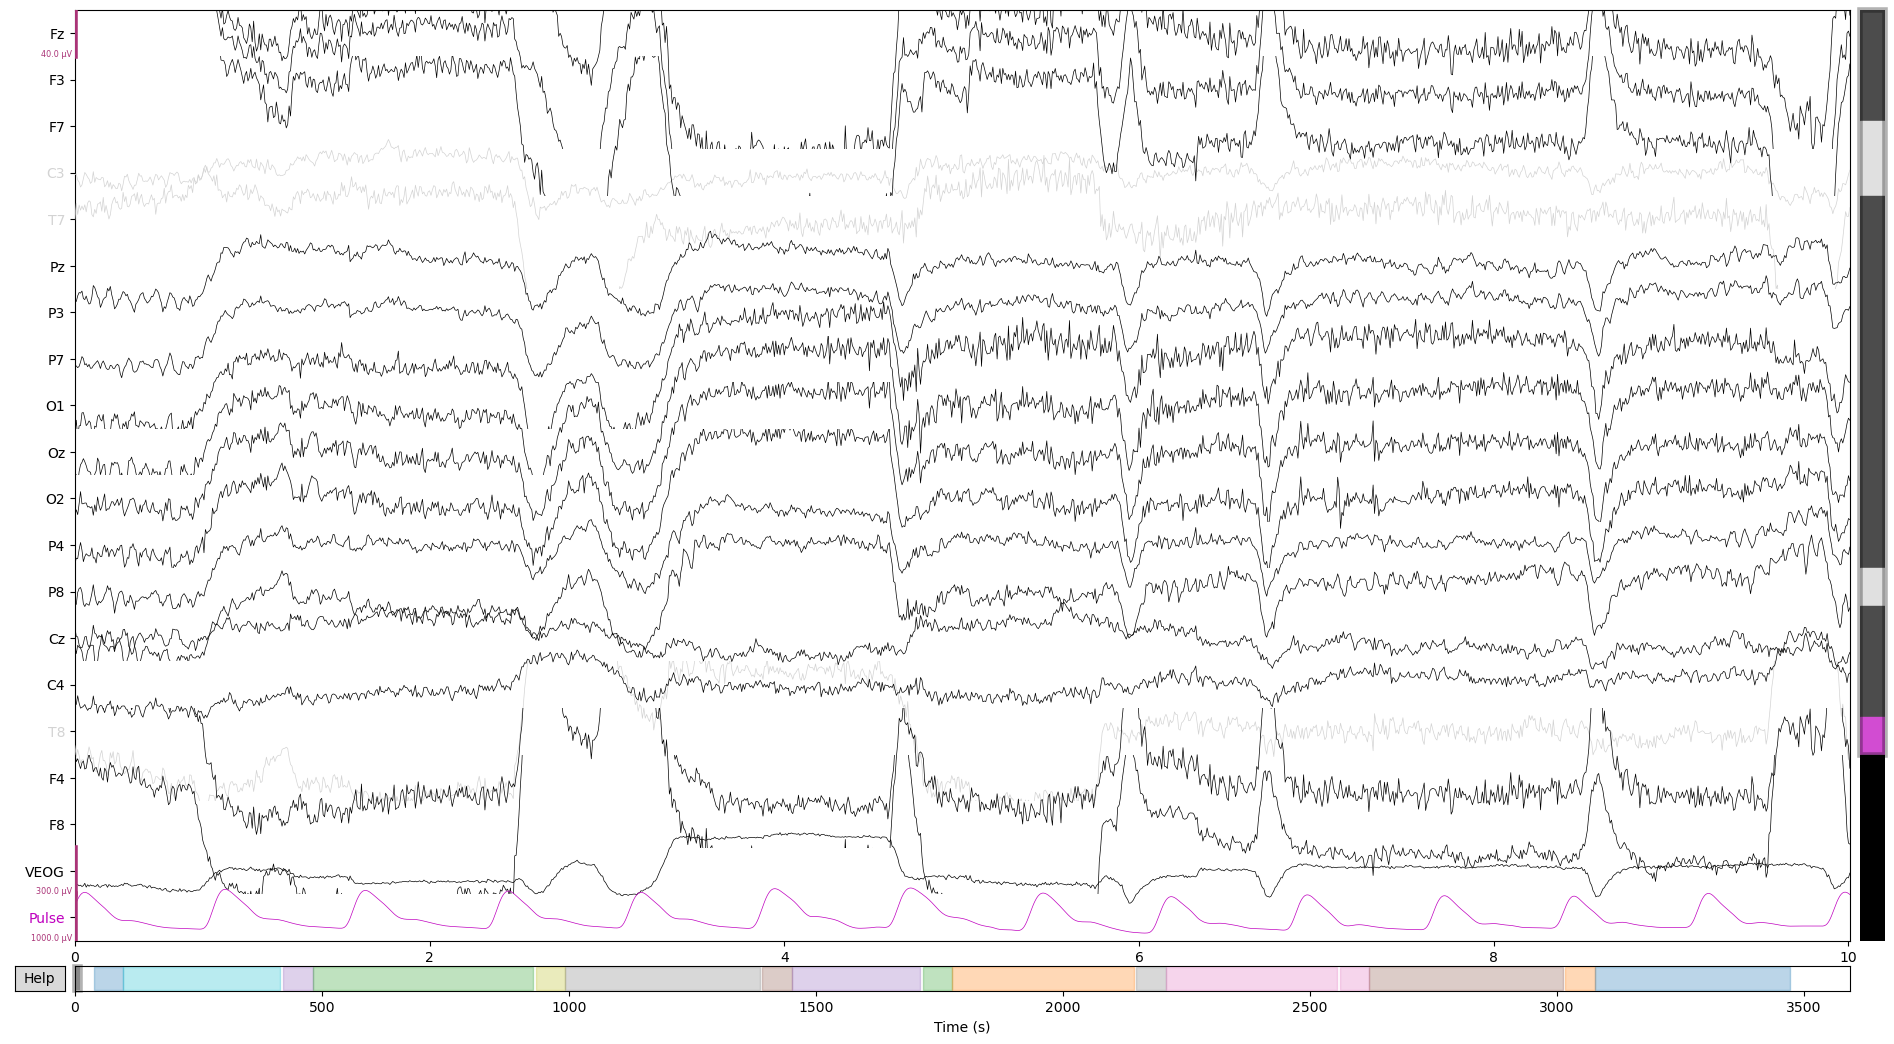

Channels marked as bad: ['C3', 'T7', 'T8']


In [67]:
new_raw.plot()

In [ ]:
raw = new_raw

# Repairing EOG artifacts with ICA

In [71]:
from mne.preprocessing import ICA

In [72]:
raw.filter(0.05, 30)
ica = ICA(random_state=97)
ica.fit(raw)

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.05 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.05
- Lower transition bandwidth: 0.05 Hz (-6 dB cutoff frequency: 0.03 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 8251 samples (66.008 sec)

Fitting ICA to data using 15 channels (please be patient, this may take a while)
Selecting by non-zero PCA components: 11 components
Fitting ICA took 7.5s.


Method,fastica
Fit,57 iterations on raw data (449078 samples)
ICA components,11
Explained variance,100.0 %
Available PCA components,15
Channel types,eeg
ICA components marked for exclusion,—


In [77]:
ica.exclude = []
# find which ICs match the EOG pattern
eog_indices, eog_scores = ica.find_bads_eog(raw, ch_name="VEOG", threshold=2.0)

Using EOG channel: VEOG
... filtering ICA sources
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 1250 samples (10.000 sec)

... filtering target
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)

In [78]:
eog_indices

[0]

In [79]:
ica.exclude = [eog_indices[0]]

Creating RawArray with float64 data, n_channels=13, n_times=449078
    Range : 0 ... 449077 =      0.000 ...  3592.616 secs
Ready.


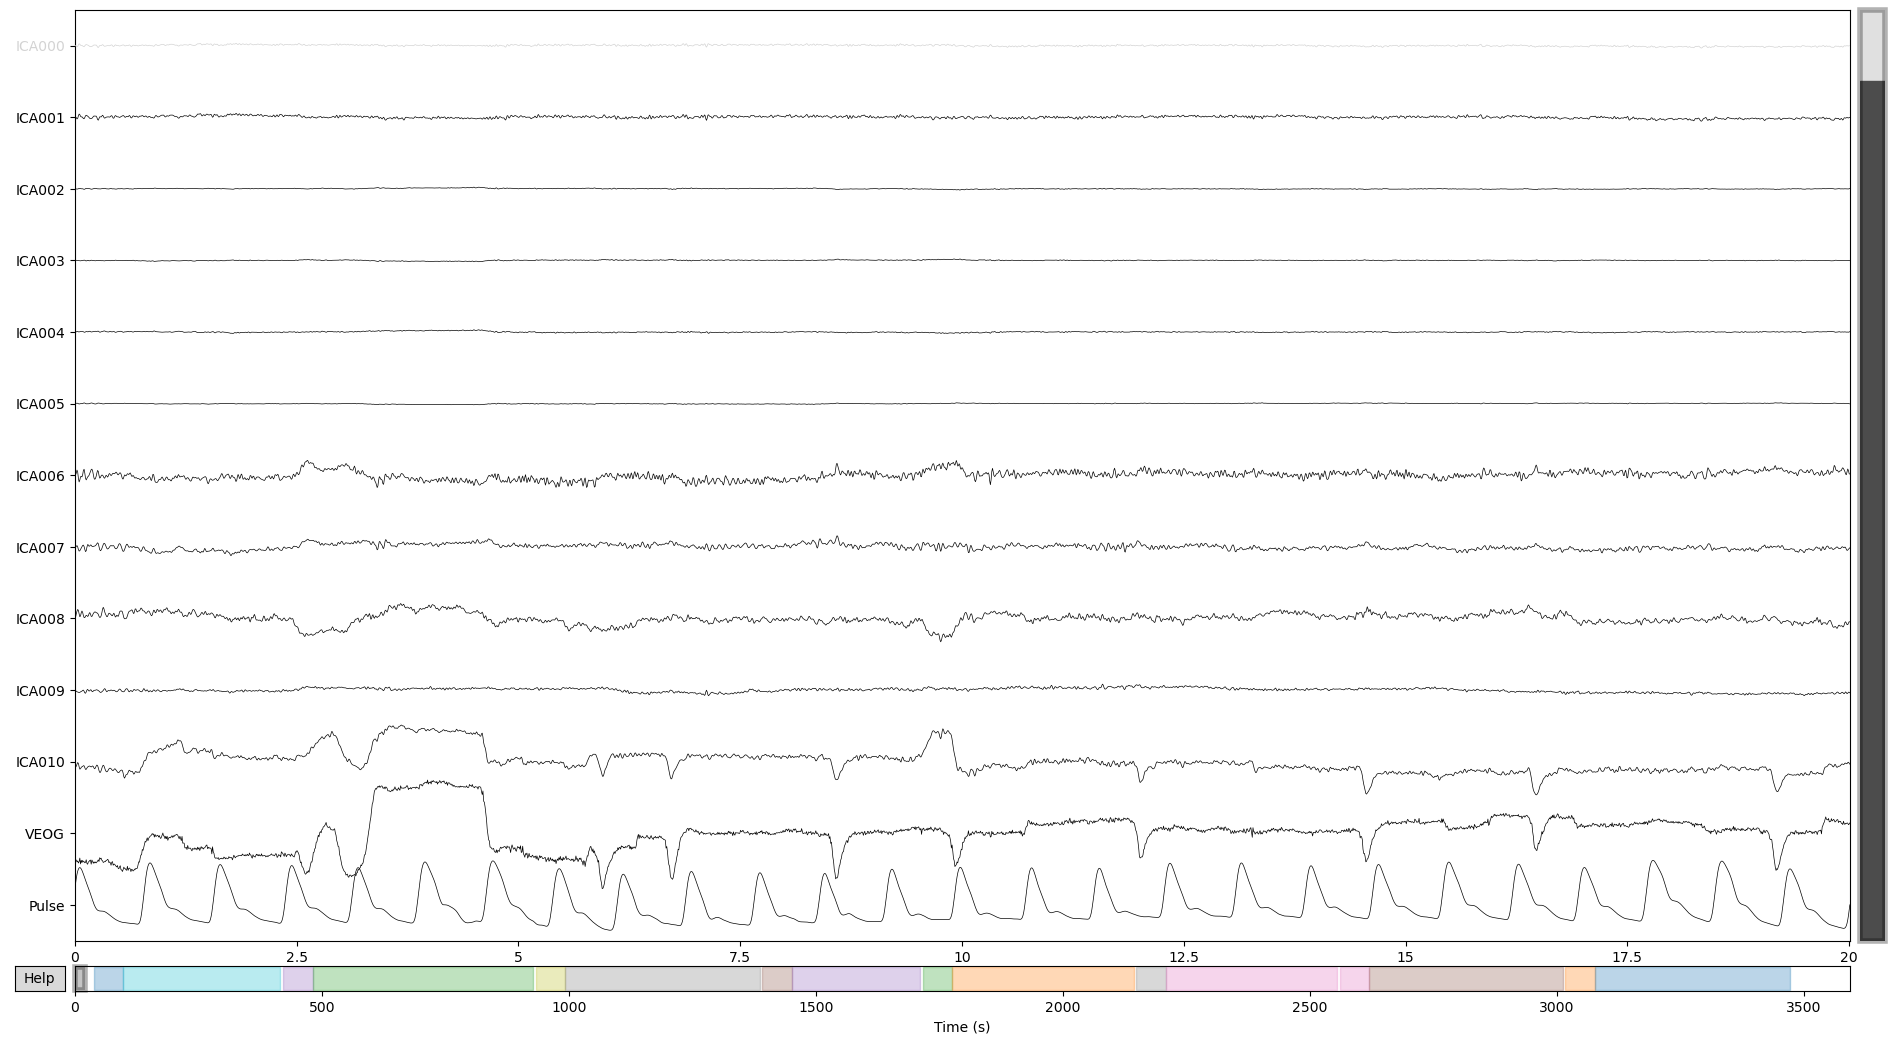

In [80]:
ica.plot_sources(raw)

In [81]:
ica.plot_scores(eog_scores)

In [82]:
raw.load_data()
ica.plot_overlay(raw, exclude=[eog_indices[0]], picks="eeg")

Applying ICA to Raw instance
    Transforming to ICA space (11 components)
    Zeroing out 1 ICA component
    Projecting back using 15 PCA components


In [83]:
ica.plot_properties(raw, picks=[eog_indices[0]])

    Using multitaper spectrum estimation with 7 DPSS windows
Not setting metadata
Not setting metadata
1796 matching events found
No baseline correction applied
0 projection items activated
0 bad epochs dropped
Not setting metadata
Not setting metadata
1796 matching events found
No baseline correction applied
0 projection items activated
0 bad epochs dropped


In [ ]:
ica.apply(raw)

# Save cleaned data

In [ ]:
raw.save("S21_raw.fif")